# Sentinel-1 data in Python

**OpenGeoHub Summer School 2023**

- Lorena Abad
- 2023-08-31

## Querying S1-SLC data

Sentinel-1 data comes at different levels and provides different products. For applications such as measuring deformation due to tectonic or volcanic activity, quantifying ground subsidence or to generate digital elevation models (DEM), [interferometric SAR (InSAR)](https://en.wikipedia.org/wiki/Interferometric_synthetic-aperture_radar) techniques can be used. 

To apply such workflows with Sentinel data, we can use [Sentinel-1 Level 1 Single Look Complex](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1/single-look-complex/interferometric-wide-swath) products.

![](https://sentinels.copernicus.eu/documents/247904/1824983/Sentinel-1-core-fig-1.jpg)

SM mode is designed to support ERS (European Remote Sensing) and Envisat missions; IW mode is the default mode over land; EW mode is designed for maritime, ice, and polar zone observation services where wide coverage and short revisit times are demanded; and WV mode is the default mode over the open ocean.

So far, very few cloud computing capabilities are available to compute such complex workflows, therefore, there is still a need to download data. Depending on the application, we will need to download data with certain characteristics. 

<img src="https://www.mdpi.com/remotesensing/remotesensing-09-00638/article_deploy/html/images/remotesensing-09-00638-g002.png" alt="InSAR principles" style="width: 500px;"/>

> Figure from: Xiong S, Muller J-P, Li G. The Application of ALOS/PALSAR InSAR to Measure Subsurface Penetration Depths in Deserts. Remote Sensing. 2017; 9(6):638. https://doi.org/10.3390/rs9060638

[Note on terminology](https://earthenable.wordpress.com/2020/08/11/new-insar-terminology-coming-in-vogue-master-slave-to-reference-secondary/).

For DEM generation, for example, we would require a pair of Sentinel-1 scenes acquired closely in time and that have a perpendicular baseline between 150 and 300 m. Usually, computing the perpendicular baseline between two images requires the download of the image pairs. 

To avoid downloading several unnecessary Sentinel-1 scenes, we can make use of the [Alaska Satellite Facility (ASF)](https://search.asf.alaska.edu/) geographic and baseline tools to query the data we need via their API.

Libraries needed for this exercise are imported below:

In [1]:
import asf_search as asf
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Define extent

We will define an aoi and a start and end date for our queries.

In [2]:
aoi = gpd.read_file("../../data/poznan.geojson")
aoi.explore()

In [7]:
footprint = aoi.to_wkt()
date_start = "2022/05/01"
date_end = "2022/10/01"
footprint.geometry[0]

'POLYGON ((16.757384 52.535648, 16.757384 52.293644, 17.163617 52.293644, 17.163617 52.535648, 16.757384 52.535648))'

### Geographical search

Now we can use the [`asf_search` Python module](https://docs.asf.alaska.edu/asf_search/basics/) to perform our geographical search. We specify here the platform and the processing level (SLC) that we are looking for, and we limit the results for this exercise to 10 scenes.

In [15]:
products = asf.geo_search(platform=[asf.PLATFORM.SENTINEL1],
                          intersectsWith=footprint.geometry[0],
                          processingLevel=[asf.PRODUCT_TYPE.SLC],
                          beamSwath='IW',
                          start=date_start,
                          end=date_end,
                          maxResults=10)

We can then add the results of the query to a pandas dataframe for easier inspection:

In [14]:
products

ASFSearchResults([])

In [10]:
products_df = pd.DataFrame([p.properties for p in products])
products_df

,beamModeType,browse,bytes,centerLat,centerLon,faradayRotation,fileID,flightDirection,groupID,granuleType,...,processingDate,processingLevel,sceneName,sensor,startTime,stopTime,url,pgeVersion,fileName,frameNumber
0,IW,None,4657751122,52.2492,17.9661,None,S1A_IW_SLC__1SDV_20220929T163603_20220929T1636...,ASCENDING,S1A_IWDV_0167_0173_045222_175,SENTINEL_1A_FRAME,...,2022-09-29T16:36:03.000Z,SLC,S1A_IW_SLC__1SDV_20220929T163603_20220929T1636...,C-SAR,2022-09-29T16:36:03.000Z,2022-09-29T16:36:30.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20220929T163603_20220929T1636...,167
1,IW,None,4580763215,52.6218,18.4544,None,S1A_IW_SLC__1SDV_20220926T050057_20220926T0501...,DESCENDING,S1A_IWDV_0416_0423_045171_124,SENTINEL_1A_FRAME,...,2022-09-26T05:00:57.000Z,SLC,S1A_IW_SLC__1SDV_20220926T050057_20220926T0501...,C-SAR,2022-09-26T05:00:57.000Z,2022-09-26T05:01:24.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20220926T050057_20220926T0501...,417
2,IW,None,4609579705,53.0143,15.6840,None,S1A_IW_SLC__1SDV_20220922T164428_20220922T1644...,ASCENDING,S1A_IWDV_0169_0176_045120_073,SENTINEL_1A_FRAME,...,2022-09-22T16:44:28.000Z,SLC,S1A_IW_SLC__1SDV_20220922T164428_20220922T1644...,C-SAR,2022-09-22T16:44:28.000Z,2022-09-22T16:44:56.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20220922T164428_20220922T1644...,170
3,IW,None,4646654586,51.5302,16.1188,None,S1A_IW_SLC__1SDV_20220922T164404_20220922T1644...,ASCENDING,S1A_IWDV_0165_0170_045120_073,SENTINEL_1A_FRAME,...,2022-09-22T16:44:04.000Z,SLC,S1A_IW_SLC__1SDV_20220922T164404_20220922T1644...,C-SAR,2022-09-22T16:44:04.000Z,2022-09-22T16:44:31.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20220922T164404_20220922T1644...,165
4,IW,None,4686861613,53.0102,16.5167,None,S1A_IW_SLC__1SDV_20220919T050904_20220919T0509...,DESCENDING,S1A_IWDV_0415_0421_045069_022,SENTINEL_1A_FRAME,...,2022-09-19T05:09:04.000Z,SLC,S1A_IW_SLC__1SDV_20220919T050904_20220919T0509...,C-SAR,2022-09-19T05:09:04.000Z,2022-09-19T05:09:31.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20220919T050904_20220919T0509...,415
5,IW,None,4652270299,52.2492,17.9662,None,S1A_IW_SLC__1SDV_20220917T163602_20220917T1636...,ASCENDING,S1A_IWDV_0167_0173_045047_175,SENTINEL_1A_FRAME,...,2022-09-17T16:36:02.000Z,SLC,S1A_IW_SLC__1SDV_20220917T163602_20220917T1636...,C-SAR,2022-09-17T16:36:02.000Z,2022-09-17T16:36:30.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20220917T163602_20220917T1636...,167
6,IW,None,4734573721,52.6220,18.4523,None,S1A_IW_SLC__1SDV_20220914T050057_20220914T0501...,DESCENDING,S1A_IWDV_0416_0423_044996_124,SENTINEL_1A_FRAME,...,2022-09-14T05:00:57.000Z,SLC,S1A_IW_SLC__1SDV_20220914T050057_20220914T0501...,C-SAR,2022-09-14T05:00:57.000Z,2022-09-14T05:01:24.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20220914T050057_20220914T0501...,417
7,IW,None,4707081403,53.0145,15.6814,None,S1A_IW_SLC__1SDV_20220910T164429_20220910T1644...,ASCENDING,S1A_IWDV_0169_0176_044945_073,SENTINEL_1A_FRAME,...,2022-09-10T16:44:29.000Z,SLC,S1A_IW_SLC__1SDV_20220910T164429_20220910T1644...,C-SAR,2022-09-10T16:44:29.000Z,2022-09-10T16:44:56.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20220910T164429_20220910T1644...,170
8,IW,None,4721237800,51.5303,16.1161,None,S1A_IW_SLC__1SDV_20220910T164404_20220910T1644...,ASCENDING,S1A_IWDV_0164_0171_044945_073,SENTINEL_1A_FRAME,...,2022-09-10T16:44:04.000Z,SLC,S1A_IW_SLC__1SDV_20220910T164404_20220910T1644...,C-SAR,2022-09-10T16:44:04.000Z,2022-09-10T16:44:32.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20220910T164404_20220910T1644...,165
9,IW,None,4575317676,53.0107,16.5132,None,S1A_IW_SLC__1SDV_20220907T050904_20220907T0509...,DESCENDING,S1A_IWDV_0415_0421_044894_022,SENTINEL_1A_FRAME,...,2022-09-07T05:09:04.000Z,SLC,

Ascending vs. Descending:
<img src="https://site.tre-altamira.com/wp-content/uploads/ascending-and-descending-orbits.png" alt="Schema pass" style="width: 250px;"/> - <img src="https://pbs.twimg.com/media/FamfGWGWIAAhMLv?format=jpg&name=900x900" alt="Ascending pass" style="width: 250px;"/> - <img src="https://pbs.twimg.com/media/FamfGsMWYAIVV5v?format=jpg&name=900x900" alt="Descending pass" style="width: 250px;"/>"/>

### Baseline search

Now that we have scenes that intersect with our defined extent, we can do a baseline search that will allow us to fetch all the S1 scenes that pair with the first S1 result from our geographical query. The baseline search returns a set of products with precomputed perpendicular baselines, so that we can focus our download on the data that we need. 

In [16]:
stack = products[0].stack()

In [17]:
print(f'{len(stack)} products found in stack')

446 products found in stack


We can take a look at the data again as a pandas data frame and we will see that the last two columns correspond to the temporal and perpendicular baseline. 

In [19]:
stack_df = pd.DataFrame([p.properties for p in stack])
stack_df.sort_values('perpendicularBaseline')

,beamModeType,browse,bytes,centerLat,centerLon,faradayRotation,fileID,flightDirection,groupID,granuleType,...,sceneName,sensor,startTime,stopTime,url,pgeVersion,fileName,frameNumber,temporalBaseline,perpendicularBaseline
416,IW,None,4563266039,52.2489,17.9638,None,S1A_IW_SLC__1SDV_20220905T163603_20220905T1636...,ASCENDING,S1A_IWDV_0167_0173_044872_175,SENTINEL_1A_FRAME,...,S1A_IW_SLC__1SDV_20220905T163603_20220905T1636...,C-SAR,2022-09-05T16:36:03.000Z,2022-09-05T16:36:30.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20220905T163603_20220905T1636...,167,-24,-184.0
111,IW,None,4745376346,51.4741,18.1578,None,S1B_IW_SLC__1SDV_20170504T163429_20170504T1634...,ASCENDING,S1B_IWDV_0165_0170_005451_175,SENTINEL_1B_FRAME,...,S1B_IW_SLC__1SDV_20170504T163429_20170504T1634...,C-SAR,2017-05-04T16:34:29.000Z,2017-05-04T16:34:56.000Z,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,002.82,S1B_IW_SLC__1SDV_20170504T163429_20170504T1634...,165,-1974,-117.0
110,IW,None,5629299887,53.0986,17.6801,None,S1B_IW_SLC__1SDV_20170504T163454_20170504T1635...,ASCENDING,S1B_IWDV_0170_0176_005451_175,SENTINEL_1B_FRAME,...,S1B_IW_SLC__1SDV_20170504T163454_20170504T1635...,C-SAR,2017-05-04T16:34:54.000Z,2017-05-04T16:35:26.000Z,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,002.82,S1B_IW_SLC__1SDV_20170504T163454_20170504T1635...,170,-1974,-114.0
321,IW,None,4696301380,52.2496,17.9639,None,S1A_IW_SLC__1SDV_20201009T163551_20201009T1636...,ASCENDING,S1A_IWDV_0167_0173_034722_175,SENTINEL_1A_FRAME,...,S1A_IW_SLC__1SDV_20201009T163551_20201009T1636...,C-SAR,2020-10-09T16:35:51.000Z,2020-10-09T16:36:18.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.31,S1A_IW_SLC__1SDV_20201009T163551_20201009T1636...,167,-720,-99.0
99,IW,None,4698539592,51.4743,18.1576,None,S1B_IW_SLC__1SDV_20170317T163428_20170317T1634...,ASCENDING,S1B_IWDV_0165_0170_004751_175,SENTINEL_1B_FRAME,...,S1B_IW_SLC__1SDV_20170317T163428_20170317T1634...,C-SAR,2017-03-17T16:34:28.000Z,2017-03-17T16:34:54.000Z,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,002.72,S1B_IW_SLC__1SDV_20170317T163428_20170317T1634...,165,-2022,-91.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,IW,None,4664583363,52.2503,17.9663,None,S1A_IW_SLC__1SDV_20190205T163535_20190205T1636...,ASCENDING,S1A_IWDV_0167_0173_025797_175,SENTINEL_1A_FRAME,...,S1A_IW_SLC__1SDV_20190205T163535_20190205T1636...,C-SAR,2019-02-05T16:35:35.000Z,2019-02-05T16:36:02.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,002.91,S1A_IW_SLC__1SDV_20190205T163535_20190205T1636...,167,-1332,173.0
429,IW,None,4536281700,52.2498,17.9679,None,S1A_IW_SLC__1SDV_20230208T163559_20230208T1636...,ASCENDING,S1A_IWDV_0167_0173_047147_175,SENTINEL_1A_FRAME,...,S1A_IW_SLC__1SDV_20230208T163559_20230208T1636...,C-SAR,2023-02-08T16:35:59.000Z,2023-02-08T16:36:26.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20230208T163559_20230208T1636...,167,132,178.0
72,IW,None,6584072949,53.2640,17.6334,None,S1B_IW_SLC__1SDV_20161129T163455_20161129T1635...,ASCENDING,S1B_IWDV_0170_0177_003176_175,SENTINEL_1B_FRAME,...,S1B_IW_SLC__1SDV_20161129T163455_20161129T1635...,C-SAR,2016-11-29T16:34:55.000Z,2016-11-29T16:35:33.000Z,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,002.72,S1B_IW_SLC__1SDV_20161129T163455_20161129T1635...,170,-2130,185.0
425,IW,None,4732915777,52.2497,17.9671,None,S1A_IW_SLC__1SDV_20221222T163601_20221222T1636...,ASCENDING,S1A_IWDV_0167_0173_046447_175,SENTINEL_1A_FRAME,...,S1A_IW_SLC__1SDV_20221222T163601_20221222T1636...,C-SAR,2022-12-22T16:36:01.000Z,2022-12-22T16:36:28.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20221222T163601_20221222T1636...,167,84,191.0


To have an idea of how spread our data is, we can plot the temporal and the perpendicular baselines against each other.

<Axes: xlabel='temporalBaseline', ylabel='perpendicularBaseline'>

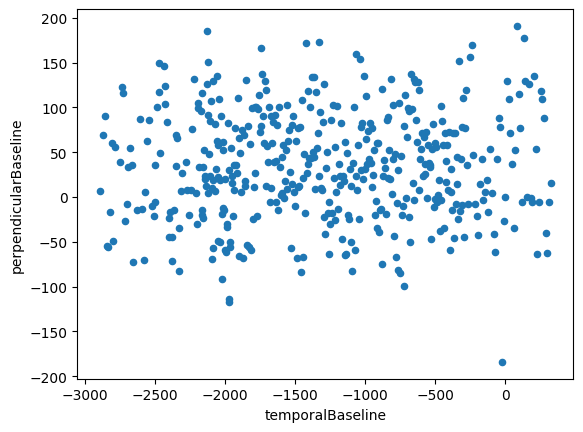

In [20]:
stack_df.plot.scatter(x="temporalBaseline", y="perpendicularBaseline")

Ideally, we will filter those values where `temporalBaseline <= 30` and `150 <= perpendicularBaseline <= 300` for instance to get image pairs suitable for DEM generation. So we can filter our data frame for those values. We look for absolute values since the order of the images is not relevant.

In [21]:
stack_df[(abs(stack_df['temporalBaseline']) <= 30) &
         (abs(stack_df['perpendicularBaseline']) >= 150) &
         (abs(stack_df['perpendicularBaseline']) <= 300)]

,beamModeType,browse,bytes,centerLat,centerLon,faradayRotation,fileID,flightDirection,groupID,granuleType,...,sceneName,sensor,startTime,stopTime,url,pgeVersion,fileName,frameNumber,temporalBaseline,perpendicularBaseline
416,IW,None,4563266039,52.2489,17.9638,None,S1A_IW_SLC__1SDV_20220905T163603_20220905T1636...,ASCENDING,S1A_IWDV_0167_0173_044872_175,SENTINEL_1A_FRAME,...,S1A_IW_SLC__1SDV_20220905T163603_20220905T1636...,C-SAR,2022-09-05T16:36:03.000Z,2022-09-05T16:36:30.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,003.52,S1A_IW_SLC__1SDV_20220905T163603_20220905T1636...,167,-24,-184.0


We only get one image fitting the characteristics we require. Let's look at its properties:

In [22]:
stack[416].properties

{'beamModeType': 'IW',
 'browse': None,
 'bytes': 4563266039,
 'centerLat': 52.2489,
 'centerLon': 17.9638,
 'faradayRotation': None,
 'fileID': 'S1A_IW_SLC__1SDV_20220905T163603_20220905T163630_044872_055BFF_5F88-SLC',
 'flightDirection': 'ASCENDING',
 'groupID': 'S1A_IWDV_0167_0173_044872_175',
 'granuleType': 'SENTINEL_1A_FRAME',
 'insarStackId': None,
 'md5sum': '72e8baa2456d336cb9b71e2c5f7e93be',
 'offNadirAngle': None,
 'orbit': 44872,
 'pathNumber': 175,
 'platform': 'Sentinel-1A',
 'pointingAngle': None,
 'polarization': 'VV+VH',
 'processingDate': '2022-09-05T16:36:03.000Z',
 'processingLevel': 'SLC',
 'sceneName': 'S1A_IW_SLC__1SDV_20220905T163603_20220905T163630_044872_055BFF_5F88',
 'sensor': 'C-SAR',
 'startTime': '2022-09-05T16:36:03.000Z',
 'stopTime': '2022-09-05T16:36:30.000Z',
 'url': 'https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_SLC__1SDV_20220905T163603_20220905T163630_044872_055BFF_5F88.zip',
 'pgeVersion': '003.52',
 'fileName': 'S1A_IW_SLC__1SDV_20220905T163603_

Let's also remember this is paired with the original product we calcualted the baselines for.

In [23]:
products[0].properties

{'beamModeType': 'IW',
 'browse': None,
 'bytes': 4657751122,
 'centerLat': 52.2492,
 'centerLon': 17.9661,
 'faradayRotation': None,
 'fileID': 'S1A_IW_SLC__1SDV_20220929T163603_20220929T163630_045222_0567B7_46CF-SLC',
 'flightDirection': 'ASCENDING',
 'groupID': 'S1A_IWDV_0167_0173_045222_175',
 'granuleType': 'SENTINEL_1A_FRAME',
 'insarStackId': None,
 'md5sum': 'a37a41c9155ed7a93b4055066710e224',
 'offNadirAngle': None,
 'orbit': 45222,
 'pathNumber': 175,
 'platform': 'Sentinel-1A',
 'pointingAngle': None,
 'polarization': 'VV+VH',
 'processingDate': '2022-09-29T16:36:03.000Z',
 'processingLevel': 'SLC',
 'sceneName': 'S1A_IW_SLC__1SDV_20220929T163603_20220929T163630_045222_0567B7_46CF',
 'sensor': 'C-SAR',
 'startTime': '2022-09-29T16:36:03.000Z',
 'stopTime': '2022-09-29T16:36:30.000Z',
 'url': 'https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_SLC__1SDV_20220929T163603_20220929T163630_045222_0567B7_46CF.zip',
 'pgeVersion': '003.52',
 'fileName': 'S1A_IW_SLC__1SDV_20220929T163603_

### Downloading the data

Finally, with the ASF API we can download our data to further analyse it with, e.g. SNAP. To do so we can make use of the url property.

In [ ]:
urls = [
    products[0].properties['url'],
    stack[416].properties['url']
]

Once that is set we can use the `download_urls()` function as speccified below to get our data in a desired directory. To download the data we will need [EarthData credentials](https://urs.earthdata.nasa.gov/). This [notebook from the ASF](https://github.com/asfadmin/Discovery-asf_search/blob/master/examples/5-Download.ipynb) describes the authentication process. 

```python
asf.download_urls(urls=urls, path='data/s1', session=user_pass_session, processes=5)
```

## Exploring S1-RTC data

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import rioxarray as rio
import xarray as xr

Now let's take a look at a bit more processed data that we can directly work with. Still in Level-1 you will see the [Ground Range Detected (GRD) product](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1-algorithms/ground-range-detected) in the figure above. This is S1 data that has been further processed (it has been detected, multi-looked and projected to ground range). The SLC products we queried before preserve phase information and are processed at the natural pixel spacing whereas GRD products contain the detected amplitude and are multi-looked to reduce the impact of speckle.

An extra processing step is to perform [Radiometric Terrain Correction](https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc), and some data providers like Microsoft Planetary Computer make this dataset available worldwide. Feel free to explore the Planetary Computer access options to work on larger datasets if you are interested. 

In the spirit to avoid the need for you to get credentials for this particular workshop, we will use a [Sentinel-1 RTC dataset for the Contiguous United States (CONUS)](https://registry.opendata.aws/sentinel-1-rtc-indigo/) which is freely accessible. 

We will access this data using the Amazon Web Services (AWS) CLI directly (with the `awscli` package). Let's explore the available data:

In [31]:
!aws s3 ls s3://sentinel-s1-rtc-indigo/tiles/RTC/1/IW/10/S/DH/2016/S1A_20160729_10SDH_ASC/ --no-sign-request

                           PRE S1A_IW_GRDH_1SSV_20160729T020719_20160729T020744_012357_013406_0D26/
2020-09-25 13:22:52   32864309 Gamma0_VV.tif
2020-09-25 13:23:01    1351178 local_incident_angle.tif


To download a scene we can directly request the data as:

In [ ]:
# Run only if you want to have 110MB of random data on your laptop!
!aws s3 cp s3://sentinel-s1-rtc-indigo/tiles/RTC/1/IW/12/R/UV/2021/S1B_20210121_12RUV_DSC/Gamma0_VV.tif S1B_20210121_12RUV_DSC/Gamma0_VV.tif --no-sign-request

The available bands have the prefix `Gamma0`. This is the result of the RTC algorithm. Read more about [the backscatter types here](https://hyp3-docs.asf.alaska.edu/guides/rtc_product_guide/#radiometry).

We will also see that the data has a suffix, either VV or VH, this is the polarization. That refers to the way data is collected. 

<img src="https://hyp3-docs.asf.alaska.edu/images/polarizations_ASF_dashed.png" alt="Polarization" style="width: 350px;"/> <img src="https://pbs.twimg.com/media/FanwpCPXwAA5rnP?format=webp&name=900x900" alt="HH-VV" style="width: 400px;"/>

[Read more about it here](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-1-sar/product-overview/polarimetry), [here](https://learningzone.rspsoc.org.uk/index.php/Learning-Materials/Radar-Imaging/Image-Interpretation-Polarisation) and [here](https://hyp3-docs.asf.alaska.edu/guides/introduction_to_sar/).

Let's start exploring the data. For this we will use `rioxarray`. We will set an environment key to establish no sign request for AWS. And we will also be leveraging the tight integration between xarray and dask to lazily read in data via the `chunks` parameter. 

We will get both the `vv` and `vh` data.

In [32]:
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [33]:
url_vv = 's3://sentinel-s1-rtc-indigo/tiles/RTC/1/IW/10/U/CU/2019/S1B_20190109_10UCU_ASC/Gamma0_VV.tif'
url_vh = 's3://sentinel-s1-rtc-indigo/tiles/RTC/1/IW/10/U/CU/2019/S1B_20190109_10UCU_ASC/Gamma0_VH.tif'
s1_vv = rio.open_rasterio(url_vv, chunks=True)
s1_vh = rio.open_rasterio(url_vh, chunks=True)

In [34]:
s1_vv

<xarray.DataArray (band: 1, y: 5490, x: 5490)>
dask.array<open_rasterio-19cbe1dffda706ec0d650050fad8aee1<this-array>, shape=(1, 5490, 5490), dtype=float32, chunksize=(1, 5490, 5490), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05 4.098e+05
  * y            (y) float64 5.4e+06 5.4e+06 5.4e+06 ... 5.29e+06 5.29e+06
    spatial_ref  int64 0
Attributes: (12/18)
    ABSOLUTE_ORBIT_NUMBER:  14411
    AREA_OR_POINT:          Area
    DATE:                   2019-01-09
    MISSION_ID:             S1B
    NUMBER_SCENES:          2
    ORBIT_DIRECTION:        ascending
    ...                     ...
    TILE_ID:                10UCU
    VALID_PIXEL_PERCENT:    87.946
    _FillValue:             0.0
    scale_factor:           1.0
    add_offset:             0.0
    long_name:              Gamma0_VV

Let's visualize a slice of the data:

In [35]:
s1_vv_ss = s1_vv.isel(x=slice(5000, 5500), y=slice(1000, 1500)).compute()

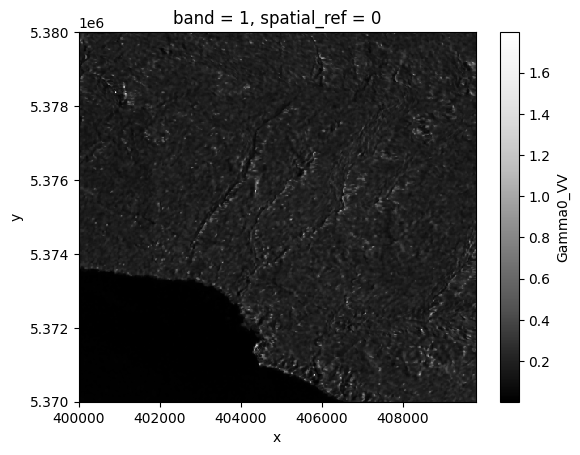

In [36]:
s1_vv_ss.plot(cmap=plt.cm.Greys_r)

To better visualize the data, we can apply a power to dB scale. This transformation applies a logarithmic scale to the data for easier visualisation, but it is not recommended to use this for any computations, since the data gets distorted. 

In [37]:
def power_to_db(input_arr):
    return (10*np.log10(np.abs(input_arr)))

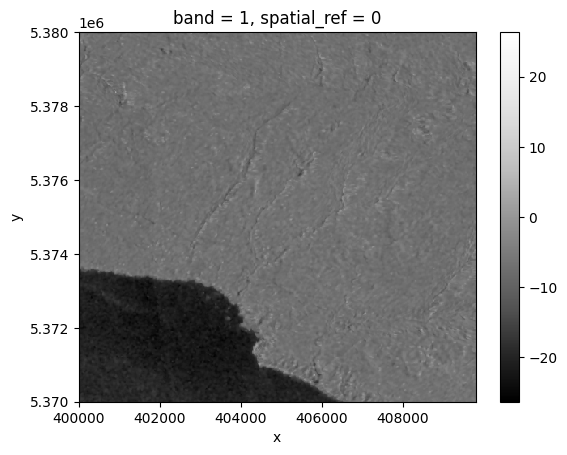

In [38]:
power_to_db(s1_vv_ss).plot(cmap=plt.cm.Greys_r)

## Exercise:

- Try to combine the `s1_vv` and `s1_vh` objects together, compute a new band with the result of `VH/VV` and use these three layers to generate a false color RGB composite. 

In [39]:
s1_rt = s1_vh/s1_vv
s1 = xr.concat([s1_vh, s1_vv, s1_rt], pd.Index(['vh', 'vv', 'vhvv'], name = 'band'))

s1

<xarray.DataArray (band: 3, y: 5490, x: 5490)>
dask.array<concatenate, shape=(3, 5490, 5490), dtype=float32, chunksize=(1, 5490, 5490), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) object 'vh' 'vv' 'vhvv'
  * x            (x) float64 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05 4.098e+05
  * y            (y) float64 5.4e+06 5.4e+06 5.4e+06 ... 5.29e+06 5.29e+06
    spatial_ref  int64 0
Attributes: (12/18)
    ABSOLUTE_ORBIT_NUMBER:  14411
    AREA_OR_POINT:          Area
    DATE:                   2019-01-09
    MISSION_ID:             S1B
    NUMBER_SCENES:          2
    ORBIT_DIRECTION:        ascending
    ...                     ...
    TILE_ID:                10UCU
    VALID_PIXEL_PERCENT:    87.946
    _FillValue:             0.0
    scale_factor:           1.0
    add_offset:             0.0
    long_name:              Gamma0_VH

In [40]:
s1_ss = s1.isel(x=slice(5000, 5500), y=slice(1000, 1500)).compute()

/opt/conda/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


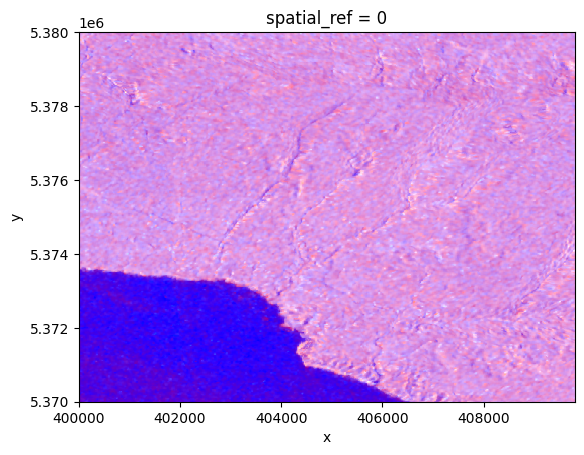

In [41]:
power_to_db(s1_ss.sel(band=["vv", "vh", "vhvv"])).plot.imshow(rgb="band", robust=True)

## More resources:

Working with Sentinel-1 SLC data can also be done with Python. There are a couple of packages available for this (`snappy` and [`snapista`](https://snap-contrib.github.io/snapista/)), but ESA is currently working on a follow up of the `snappy` package called `esa-snappy` which will be compatible with the upcoming SNAP-10. Since the [developers claim its worth the wait](https://forum.step.esa.int/t/snappy-and-snap-10-release/39606), I would at this point direct you to the webpage where they seem to be documenting basic usage of the tool. So for that [feel free to check this site more or less at the end of August](https://senbox.atlassian.net/wiki/spaces/SNAP/pages/2499051521/Configure+Python+to+use+the+new+SNAP-Python+esa+snappy+interface+SNAP+version+10).

For more complex InSAR analysis on the cloud, there are some other alternatives. Take a look at [this paper by Piter et al. (2021)](https://isprs-archives.copernicus.org/articles/XLIII-B3-2021/171/2021/isprs-archives-XLIII-B3-2021-171-2021.pdf) for an overview and comparison. There are some other attempts still under development, e.g., [dinoSAR](https://dinosar.readthedocs.io/en/latest/index.html).

A lot of the examples for this notebook, mainly for the RTC processing were adapted from Emma Marshall's excellent tutorial on [Sentinel-1 RTC data workflows with xarray](https://e-marshall.github.io/sentinel1_rtc/intro.html).